In [8]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.02f}'.format)
from geopy.distance import geodesic
from shapely.ops import linemerge
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
import contextily as ctx
from src.api import parse_zipped_gtfs
import matplotlib.pyplot as plt
from src.gtfs_segments import GTFS_shape_processor
from shapely.geometry import Point
from plotnine import *
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

## Reading our speeds from September 18 through Christmas

In [4]:
gtfs_speed = read_speeds_between_dates("2023-09-18", "2023-12-26").sample(40000000, replace=False).query("speed_mph < 70 & speed_mph > 0")

### Merge in route and segment info

In [7]:
full_trips = pd.read_parquet("/home/data/bus-weather/nyc_trip_shapes.parquet")
gtfs_speed = full_trips.merge(gtfs_speed)

In [9]:
segments = gpd.read_parquet("/home/data/bus-weather/bus_segments_2023_09_18.parquet")
ntas_url = "https://data.cityofnewyork.us/api/geospatial/d3qk-pfyz?method=export&format=GeoJSON"
ntas = gpd.read_file(ntas_url).to_crs(2263)
seg_ntas = segments.overlay(ntas)
seg_ntas["seg_length"] = seg_ntas.length
seg_ntas = seg_ntas.sort_values(["shape_id", "stop_id", "prev_stop_id", "seg_length"]).drop_duplicates(["shape_id", "stop_id", "prev_stop_id"], keep = "first")
seg_ntas = seg_ntas[["shape_id", "stop_id", "prev_stop_id", "boroname", "ntaname", "ntacode"]]

In [5]:
gtfs_speed["date"] = gtfs_speed.interpolated_time.dt.date.astype(str)
gtfs_speed["hour"] = gtfs_speed.interpolated_time.dt.hour.astype(int)
gtfs_speed["day_of_week"] = gtfs_speed["interpolated_time"].dt.dayofweek
gtfs_speed = gtfs_speed.query("~date.isin(['2023-09-17', '2023-12-26', '2023-12-27'])")

In [10]:
gtfs_speed = gtfs_speed
gtfs_speed = gtfs_speed.merge(seg_ntas)

To compare holiday speeds to oridinary speeds we first calculate the average speeds during the daytime (8am - 8pm) for each neighborhood on each day of the week. We will perform these same calculations on the holiday data and compare the speeds to estimate the impact of the holiday.

In [11]:
daytime_speeds_by_date = gtfs_speed.query("hour > 8 & hour < 20").groupby(["date", "day_of_week", "boroname", "ntaname"])["speed_mph"].describe().reset_index()
daytime_speeds = gtfs_speed.query("hour > 8 & hour < 20").groupby(["boroname", "ntaname", "day_of_week"]).agg(total_avg = ("speed_mph", "mean"),
                                                                                               total_median = ("speed_mph", "median")).reset_index()

In [12]:
daytime_speeds_by_date.query("boroname == 'Manhattan'").sort_values("mean")

,date,day_of_week,boroname,ntaname,count,mean,std,min,25%,50%,75%,max
14139,2023-11-29,2,Manhattan,Midtown-Midtown South,3801.000000,4.588337,4.186445,0.196662,2.227041,3.623944,5.702915,69.985351
109,2023-09-18,0,Manhattan,Turtle Bay-East Midtown,1284.000000,4.654913,5.380577,0.122634,1.781214,2.994190,5.281206,65.205899
104,2023-09-18,0,Manhattan,Midtown-Midtown South,3850.000000,4.899854,4.477448,0.216090,2.250884,3.888721,6.238084,68.990369
2231,2023-09-29,4,Manhattan,Chinatown,582.000000,4.933271,3.872017,0.373852,2.807171,4.177062,6.191091,51.193546
15309,2023-12-05,1,Manhattan,Midtown-Midtown South,4296.000000,5.023268,3.182427,0.108863,3.083958,4.396182,6.180754,48.668412
...,...,...,...,...,...,...,...,...,...,...,...,...
19221,2023-12-25,0,Manhattan,park-cemetery-etc-Manhattan,1530.000000,9.962853,6.400912,0.319292,5.998993,8.375105,12.276290,62.120443
19199,2023-12-25,0,Manhattan,East Harlem South,1098.000000,10.056078,5.905952,0.774176,5.792327,8.831659,13.225083,54.718632
19193,2023-12-25,0,Manhattan,Battery Park City-Lower Manhattan,515.000000,10.078465,7.811203,0.171945,6.194696,8.414450,11.392668,50.310403
12953,2023-11-23,3,Manhattan,Battery Park City-Lower Manhattan,569.000000,10.347781,7.259972,0.198318,6.662114,8.986319,12.122146,54.296559


### Thanksgiving comparisons

In [13]:
thanksgiving = daytime_speeds.merge(daytime_speeds_by_date.query("date == '2023-11-23'")[["ntaname", "day_of_week", "mean", "50%"]])
thanksgiving["diff"] = thanksgiving["mean"] - thanksgiving["total_avg"] 
thanksgiving["diff_pct"] = (thanksgiving["diff"] / thanksgiving["total_avg"]) * 100

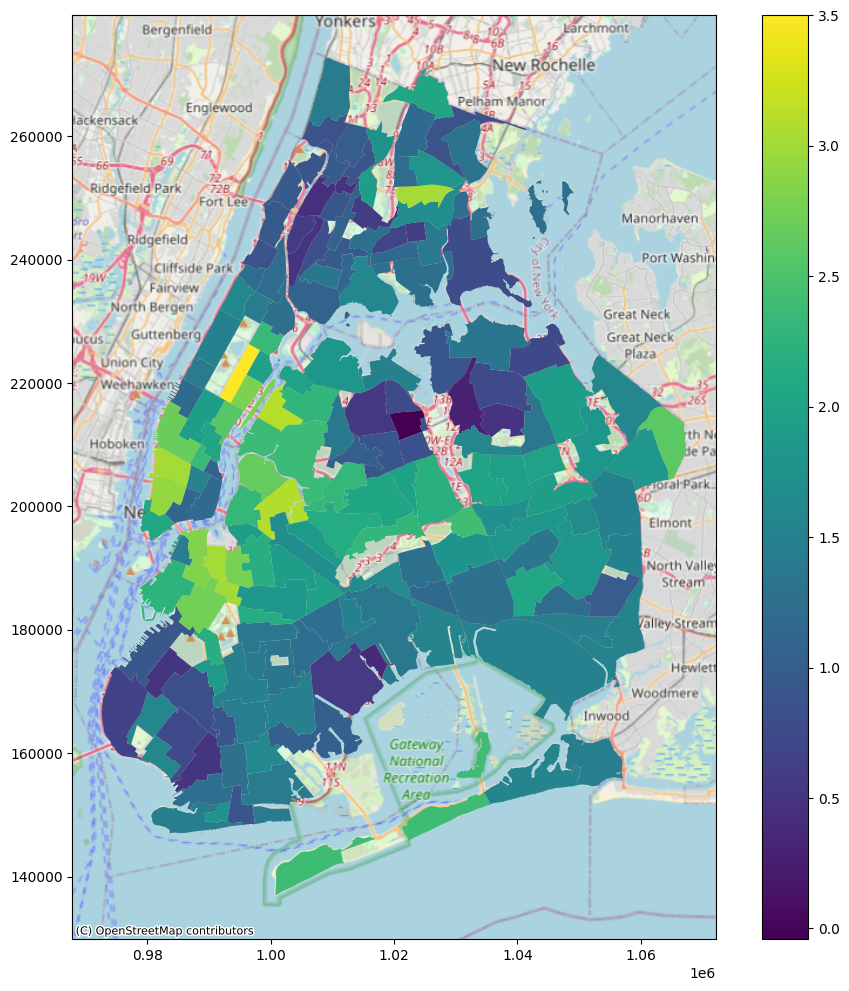

In [14]:
import contextily as ctx
import matplotlib.pyplot as plt

# Create a plot with the 'diff_pct' column from the merged GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 12))  # Set the plot size

ntas.query("~ntaname.str.contains('park-cemetery-etc') & ntaname != 'Rikers Island' & boroname != 'Staten Island'").merge(thanksgiving).plot(column="diff", ax=ax, legend=True)

# Add a basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=ntas.crs)

# Show the plot
plt.show()

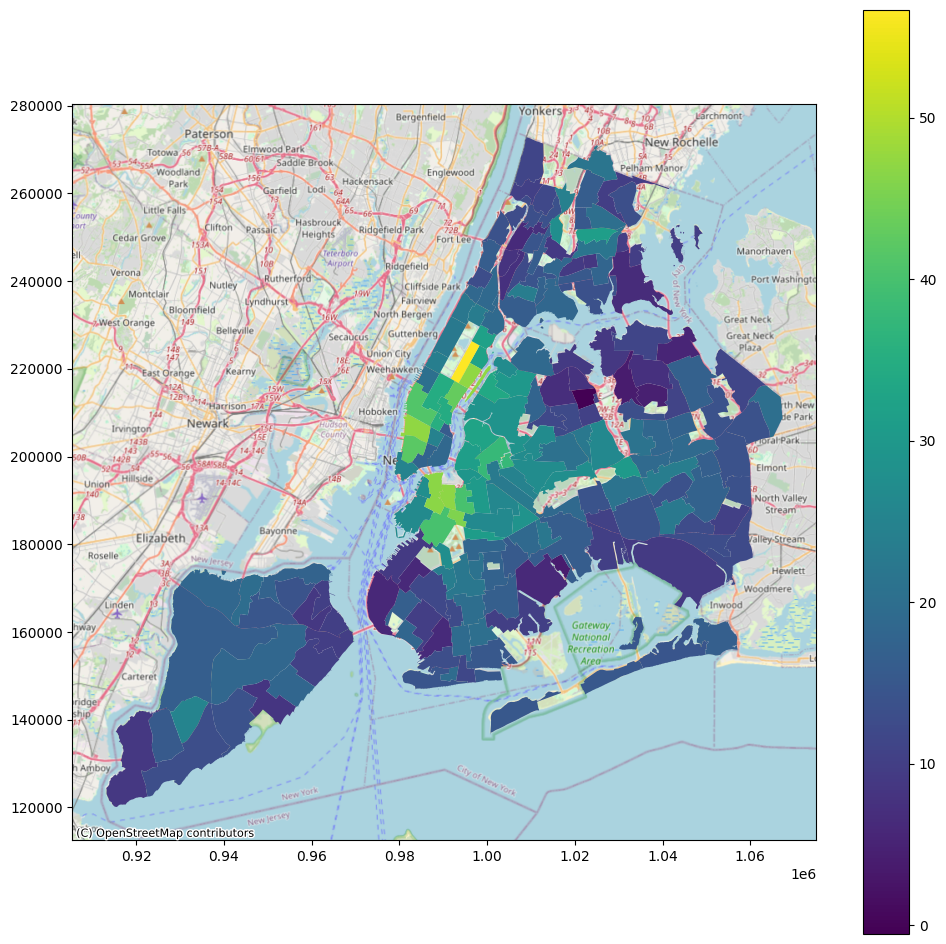

In [15]:
import contextily as ctx
import matplotlib.pyplot as plt

# Create a plot with the 'diff_pct' column from the merged GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 12))  # Set the plot size

ntas.query("~ntaname.str.contains('park-cemetery-etc') & ntaname != 'Rikers Island'").merge(thanksgiving).plot(column="diff_pct", ax=ax, legend=True)

# Add a basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=ntas.crs)

# Show the plot
plt.show()

## Christmas comparison

In [16]:
christmas = daytime_speeds.merge(daytime_speeds_by_date.query("date == '2023-12-25'")[["ntaname", "day_of_week", "mean", "50%"]])
christmas["diff"] = christmas["mean"] - christmas["total_avg"] 
christmas["diff_pct"] = (christmas["diff"] / christmas["total_avg"]) * 100

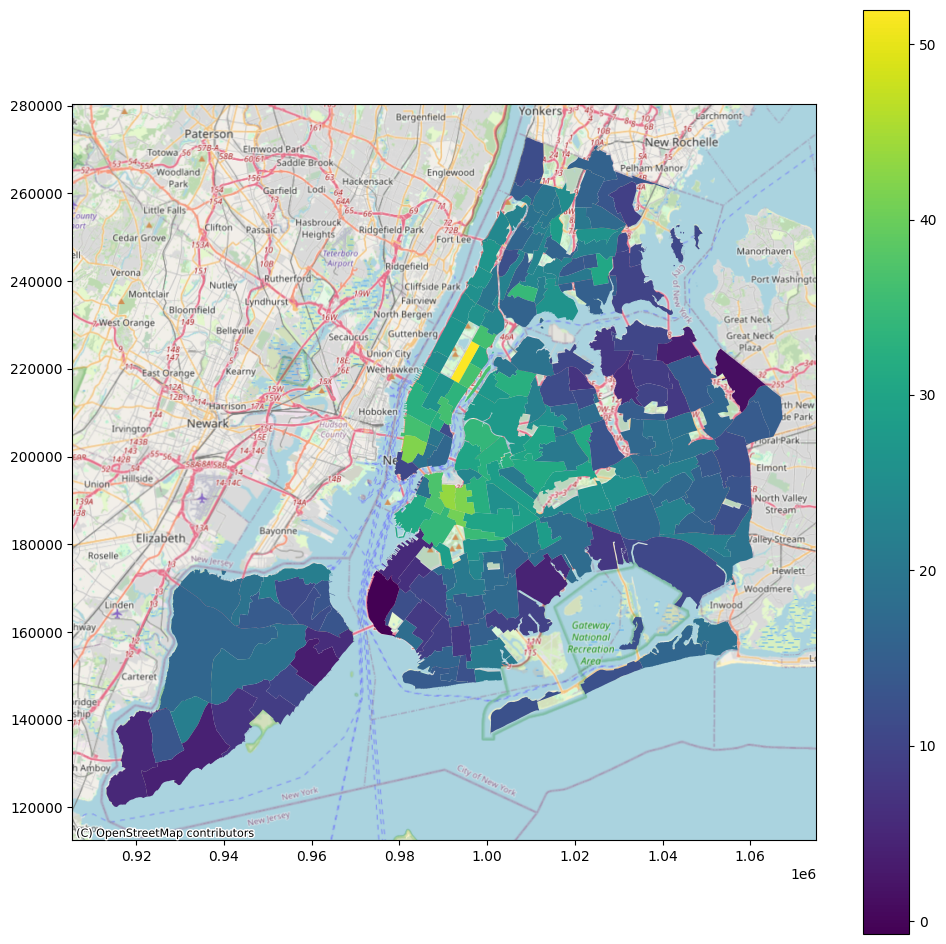

In [23]:
import contextily as ctx
import matplotlib.pyplot as plt

# Create a plot with the 'diff_pct' column from the merged GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 12))  # Set the plot size

ntas.query("~ntaname.str.contains('park-cemetery-etc') & ntaname != 'Rikers Island'").merge(christmas).plot(column="diff_pct", ax=ax, legend=True)

# Add a basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=ntas.crs)

# Show the plot
plt.show()

## UN week

In [15]:
UN_week_dates = ["2023-09-19","2023-09-20", "2023-09-21"]

In [16]:
un = daytime_speeds.merge(daytime_speeds_by_date.query("date.isin(@UN_week_dates)")[["ntaname", "mean", "50%"]])
un["diff"] = un["mean"] - un["total_avg"] 
un["diff_pct"] = (un["diff"] / un["total_avg"]) * 100

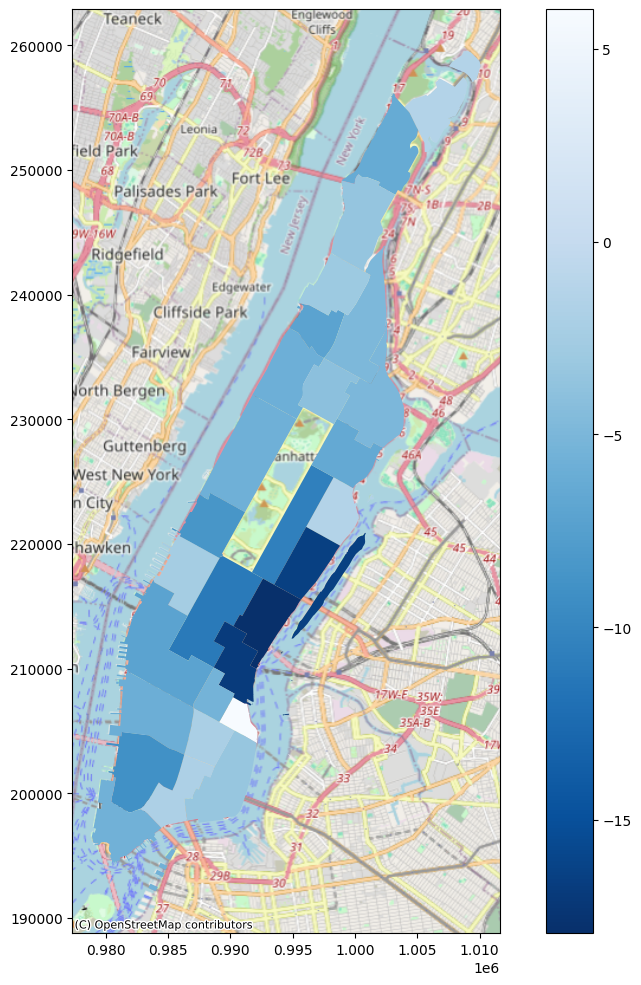

In [17]:
import contextily as ctx
import matplotlib.pyplot as plt

# Create a plot with the 'diff_pct' column from the merged GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 12))  # Set the plot size

ntas.query("~ntaname.str.contains('park-cemetery-etc')  & boroname == 'Manhattan'").merge(un.groupby("ntaname")["diff_pct"].mean().reset_index()).plot(column="diff_pct", ax=ax, legend=True, cmap = "Blues_r")

# Add a basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=ntas.crs)

# Show the plot
plt.show()